In [1]:
### Imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix

In [2]:
### Figure Aesthetics ###
# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {"ytick.major.size":10.0})
sns.set_context("poster", font_scale=1.1)
sns.set_palette('muted')

In [3]:
### Loading Data ###
train_path = '/Users/chrisbays/Desktop/train_users_2.csv'
test_path = '/Users/chrisbays/Desktop/test_users.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

#df_test.info()
#df_train.info()

In [4]:
### Merging train and test data for cleaning and analysis ###
df_all = pd.concat((df_train, df_test), axis=0 ,ignore_index=True)
df_all.drop(['date_first_booking','id'], axis=1, inplace=True)
df_all.head(5)

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


In [5]:
### Check missing data ###
def check_NaN_values(df):
    for col in df:
        nan_count = df[col].isnull().sum()
        if nan_count != 0:
            print(col + " => " + str(nan_count) + " NaN value(s)")

# Replace '-unknown-' string value in gender data with NaN value
df_all.gender.replace('-unknown-', np.nan, inplace=True)

# Check amount of NaN values          
check_NaN_values(df_all)

# Check NaN values as percentage
df_nan = (df_all.isnull().sum()/ df_all.shape[0])*100
df_nan[df_nan>0]

age => 116866 NaN value(s)
country_destination => 62096 NaN value(s)
first_affiliate_tracked => 6085 NaN value(s)
gender => 129480 NaN value(s)


age                        42.412365
country_destination        22.535538
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64

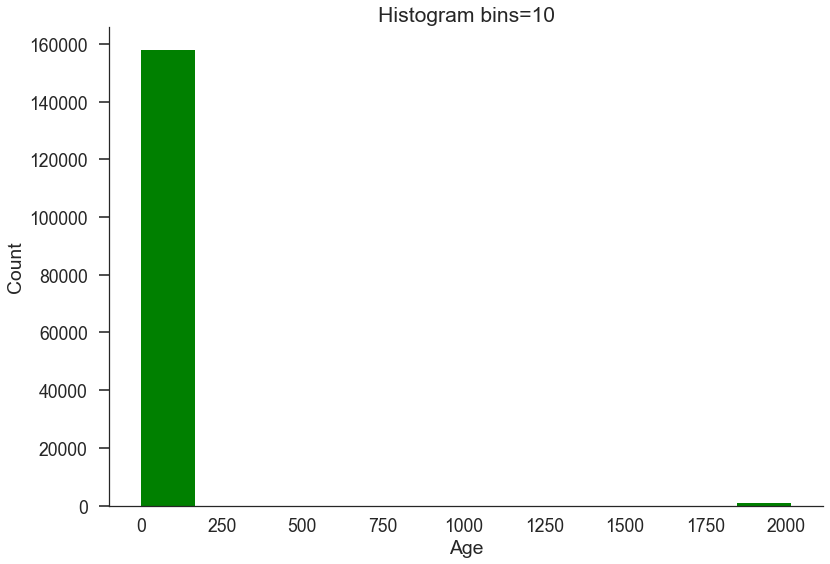

count    156003.000000
mean         36.074749
std          11.700363
min          15.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64

In [6]:
### Cleaning Age data ###
# Examine the age data
# Run this line first to examine all data
df_all.age.hist(grid=False, color='g', bins=12)
sns.despine()
plt.title('Histogram bins=10')
plt.ylabel('Count')
plt.xlabel('Age')
plt.show()

# Run this line to examine outliers
#df_all[df_all.age >1250].age.hist(bins=5)

# It seems some data was input incorrectly as birth year.
def clean_age_data(x, min_value=14, max_value=100):
    if np.logical_and(x<2000, x>1919):
        return 2015-x
    elif np.logical_or(x<min_value, x>max_value):
        return np.nan
    else:
        return x
    
df_all['age'] = df_all['age'].apply(lambda x: clean_age_data(x))

# Check the cleaned age data
df_all.age.describe()

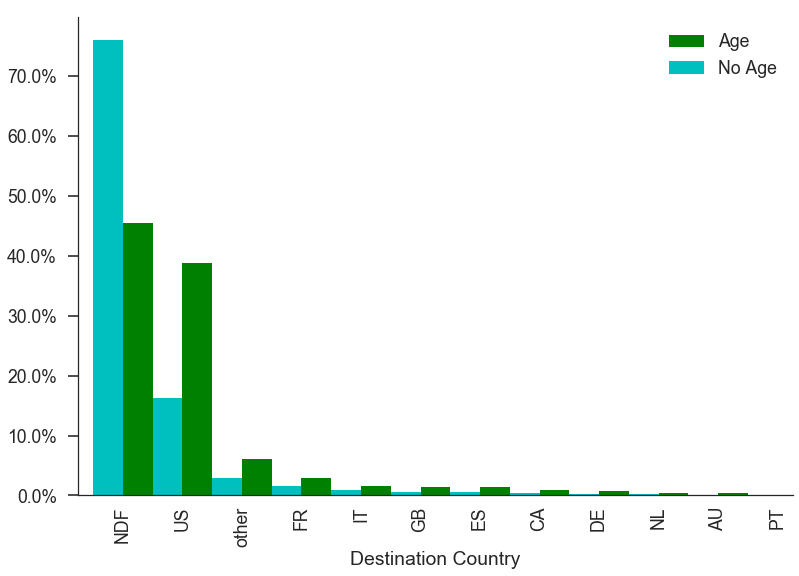

In [7]:
### Visualizing age data for missing ages and filled ages for each country destination ###
complete_age = df_all[df_all.age.notnull()].country_destination.value_counts()
missing_age = df_all[df_all.age.isnull()].country_destination.value_counts()
ax = (complete_age*100).div(complete_age.sum()).plot(kind='bar', color='g', label='Age', position=0)
ax = (missing_age*100).div(missing_age.sum()).plot(kind='bar', color='c', label='No Age', position=1)
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.legend()
plt.xlabel('Destination Country')
plt.show()

# We see that the missing ages data has many more NDF than filled ages

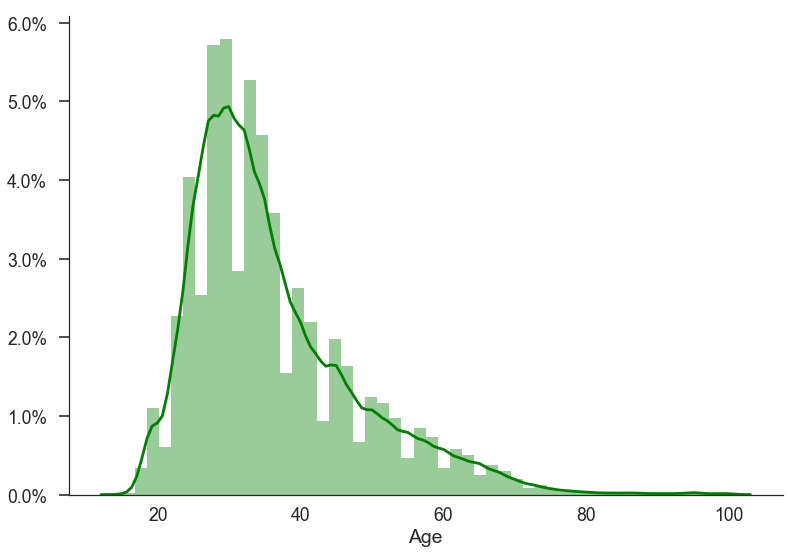

In [8]:
### Visualizing age data ###
# Set figure aesthetics
sns.set_style("white", {"ytick.major.size":10.0})
sns.set_context("poster", font_scale=1.1)
sns.set_palette('muted')
ax = sns.distplot(df_all.age.dropna(), color='g')
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()])
plt.xlabel('Age')
sns.despine()
plt.show()

# The age that users make their first booking appears to peak between 25 and 40.

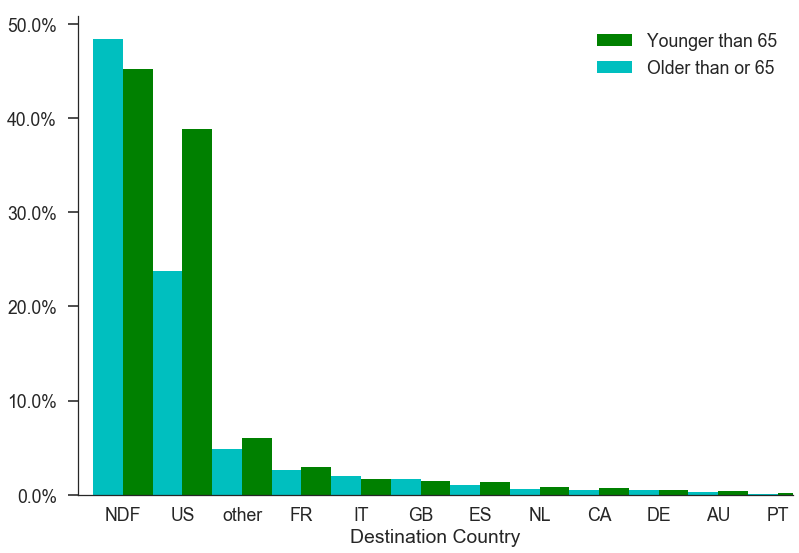

In [9]:
### Visualizing destination choice by age category ###
# Explore different ages to see differences
age = 69

younger = sum(df_all.loc[df_all['age'] < age, 'country_destination'].value_counts())
older = sum(df_all.loc[df_all['age'] >= age, 'country_destination'].value_counts())

younger_destinations = df_all.loc[df_all['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = df_all.loc[df_all['age'] > age, 'country_destination'].value_counts() / older * 100

ax = younger_destinations.plot(kind='bar', color='g', position=0, label='Younger than 65', rot=0)
ax1 = older_destinations.plot(kind='bar', color='c', position=1, label='Older than or 65', rot=0)
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in ax.get_yticks()])
ax1.set_yticklabels(['{:3.1f}%'.format(x) for x in ax1.get_yticks()])

plt.legend()
plt.xlabel('Destination Country')

sns.despine()
plt.show()

# There appears to be a significant difference in destination that peaks around ages 69-72
# The US has an overwhelming favorability compared to other countries

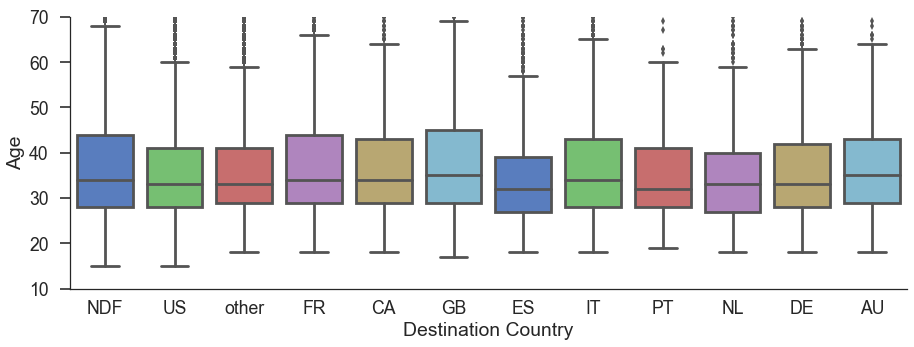

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
sns.boxplot(x='country_destination', y='age', palette='muted', data=df_all, ax=ax)
plt.ylabel('Age')
plt.xlabel('Destination Country')
ax.set_ylim([10, 70])
sns.despine()
plt.show()

('% of users that are english speakers ', 96.367588832395199)


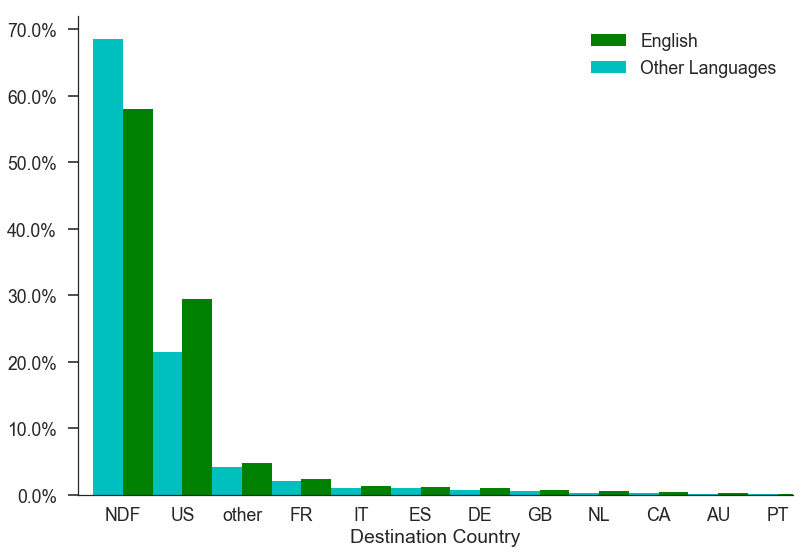

In [11]:
### Visualizing Language data ###
num=sum(df_all.language == 'en')
den = float(df_all.shape[0])
print("% of users that are english speakers ",num/den*100)

lan = 'en'

target_lan = sum(df_all.loc[df_all['language'] == lan, 'country_destination'].value_counts())
other_lan = sum(df_all.loc[df_all['language'] != lan, 'country_destination'].value_counts())

target_lan_destinations = df_all.loc[df_all['language'] == lan, 'country_destination'].value_counts() / target_lan * 100
other_lan_destinations = df_all.loc[df_all['language'] != lan, 'country_destination'].value_counts() / other_lan * 100

ax = target_lan_destinations.plot(kind='bar', color='g', position=0, label='English', rot=0)
ax1 = other_lan_destinations.plot(kind='bar', color='c', position=1, label='Other Languages', rot=0)
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in ax.get_yticks()])
ax1.set_yticklabels(['{:3.1f}%'.format(x) for x in ax1.get_yticks()])

plt.legend()
plt.xlabel('Destination Country')

sns.despine()
plt.show()

# There appears to be a greater percentage of non-english speakers with NDF and a smaller percentage that book in the US

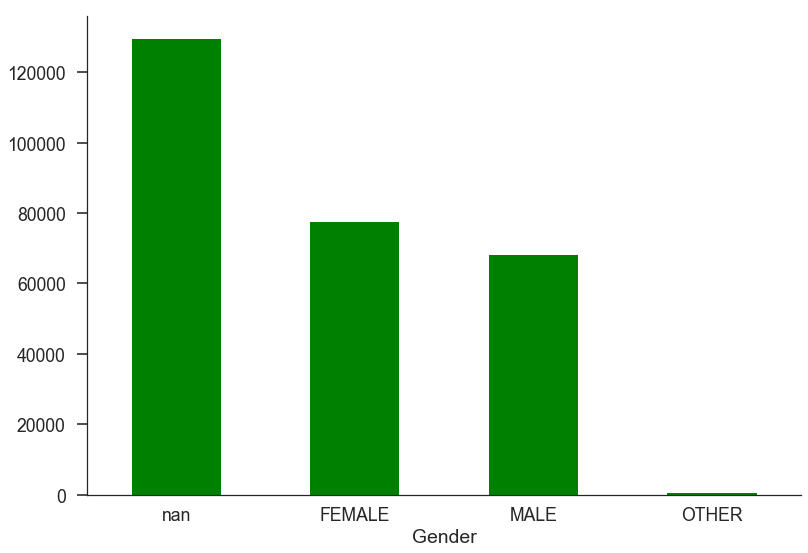

In [12]:
### Visualizing gender data ###

df_all.gender.value_counts(dropna=False).plot(kind='bar', color='g', rot=0)
plt.xlabel('Gender')
sns.despine()
plt.show()

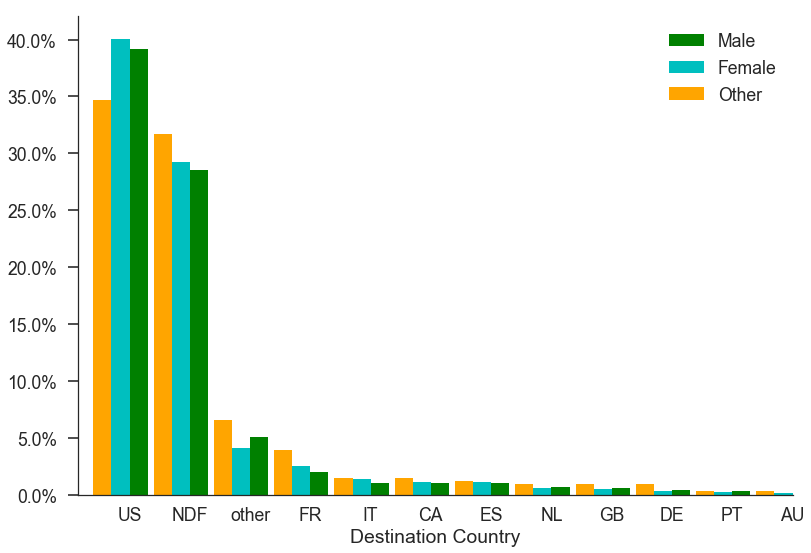

In [13]:
### Visualizing along gender feature for Destination preference ###
women = sum(df_all['gender'] == 'FEMALE')
men = sum(df_all['gender'] == 'MALE')
other = sum(df_all['gender'] == 'OTHER')

female_destinations = df_all.loc[df_all['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = df_all.loc[df_all['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100
other_destinations = df_all.loc[df_all['gender'] == 'OTHER', 'country_destination'].value_counts() / other * 100


# Bar width
width = 0.3

ax = male_destinations.plot(kind='bar', width=width, color='g', position=0, label='Male', rot=0)
ax = female_destinations.plot(kind='bar', width=width, color='c', position=1, label='Female', rot=0)
ax = other_destinations.plot(kind='bar', width=width, color='orange', position=2, label='Other', rot=0)
ax.set_yticklabels(['{:3.1f}%'.format(x) for x in ax.get_yticks()])

plt.legend()
plt.xlabel('Destination Country')


sns.despine()
plt.show()

# no major differences are apparent for gender feature

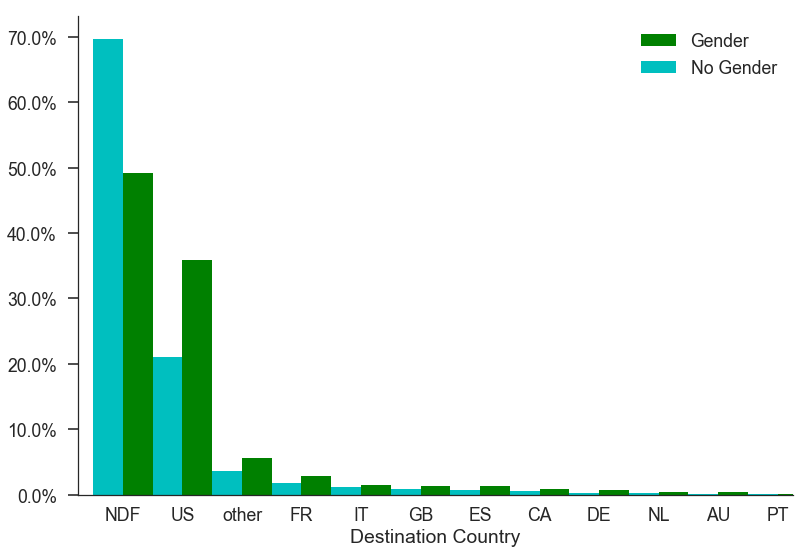

In [14]:
### Visualizing Gender data for missing genders and filled genders for each country destination ###
complete_gender = df_all[df_all.gender.notnull()].country_destination.value_counts()
missing_gender = df_all[df_all.gender.isnull()].country_destination.value_counts()
ax1 = (complete_gender).div(complete_gender.sum()).plot(kind='bar', color='g', position=0, label='Gender', rot=0)
ax1 = (missing_gender).div(missing_gender.sum()).plot(kind='bar', color='c', position=1, label='No Gender', rot=0)
ax1.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax1.get_yticks()])
sns.despine()
plt.legend()
plt.xlabel('Destination Country')
plt.show()

# We see that the missing genders data has a greater percentage of NDF than filled genders

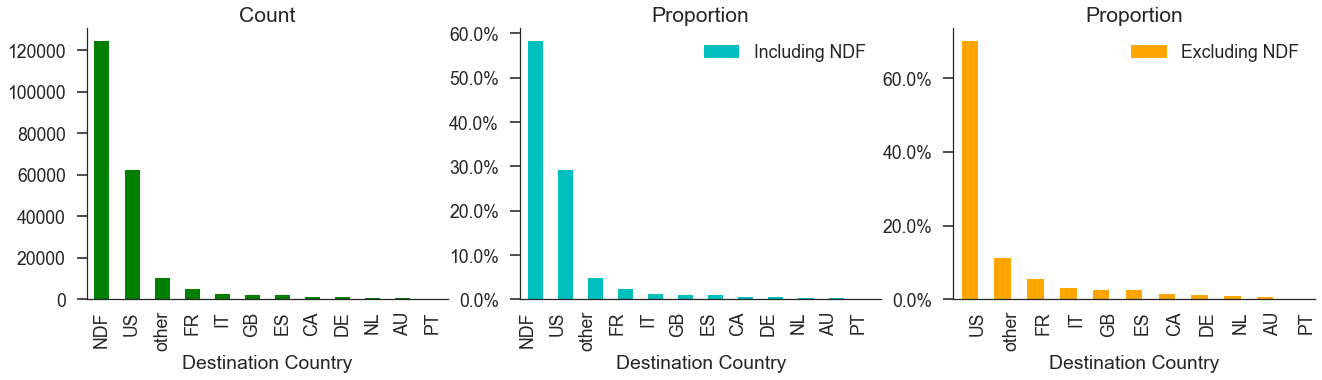

US       0.701579
other    0.113533
FR       0.056497
IT       0.031887
GB       0.026139
ES       0.025296
CA       0.016062
DE       0.011934
NL       0.008571
AU       0.006062
PT       0.002441
Name: country_destination, dtype: float64

In [15]:
### Visualizing Country Destination ###
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(22, 5))
sns.set_style("white", {"ytick.major.size":10.0})
sns.set_context("poster", font_scale=1.1)
sns.set_palette('muted')

country_counts = df_all.country_destination.value_counts()
ax = country_counts.plot(kind='bar', color='g', title='Count',ax=axes[0])
ax1 = (country_counts).div(country_counts.sum()).plot(kind='bar', title='Proportion',
                                                color='c', label='Including NDF', ax=axes[1], position=0)

booked_count = df_all[df_all.country_destination != 'NDF'].country_destination.value_counts()
booked_count_prop = booked_count.div(booked_count.sum())
ax2 = booked_count_prop.plot(kind='bar', title='Proportion',
                                                color='orange', label='Excluding NDF', ax=axes[2], position=1)
ax1.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax1.get_yticks()])
ax2.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax2.get_yticks()])
ax1.legend()
ax2.legend()
ax.set_xlabel('Destination Country')
ax1.set_xlabel('Destination Country')
ax2.set_xlabel('Destination Country')
sns.despine()
plt.show()


booked_count_prop

In [16]:
### Cleaning Date data ###
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=1.2)

df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'], format='%Y-%m-%d')

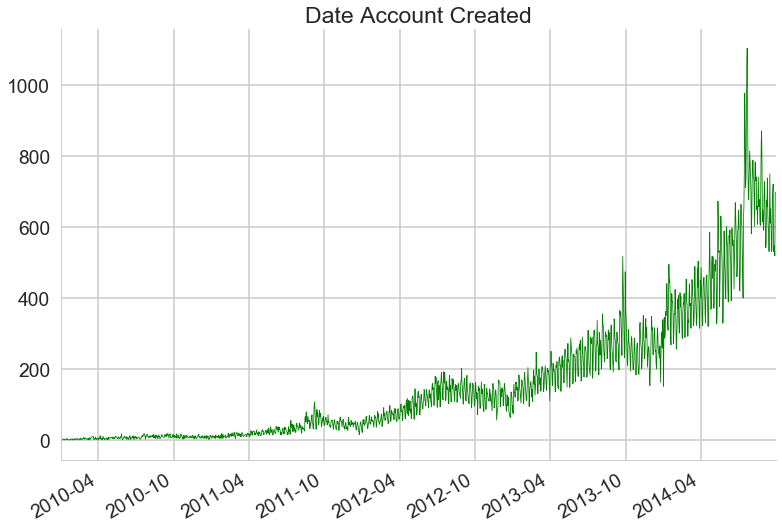

In [17]:
### Visualizing Date Account Created & Timestamp First Active ###
df_all.date_account_created.value_counts().plot(kind='line', linewidth=0.8, title='Date Account Created', color='g')
sns.despine()
plt.show()

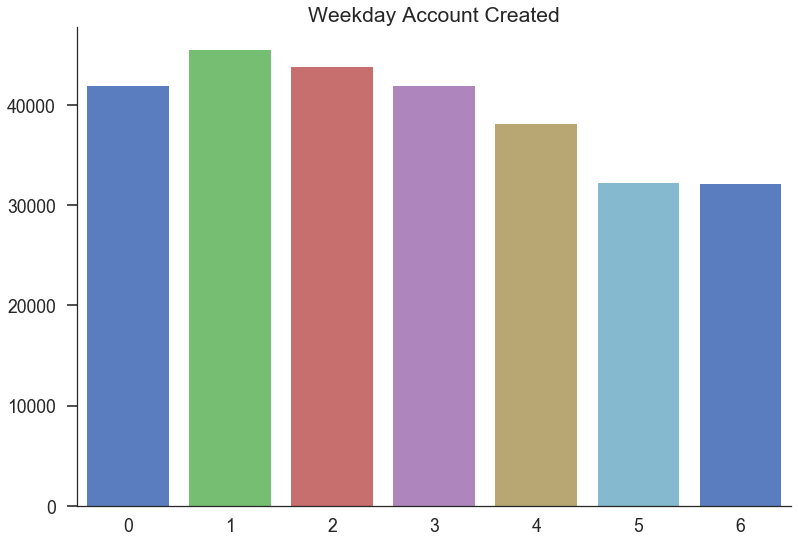

In [18]:
### Visualizing Weekdays Account Created data ###

# Set figure aesthetics
sns.set_style("white", {"ytick.major.size":10.0})
sns.set_context("poster", font_scale=1.1)
sns.set_palette('muted')

weekdays_dac = []
for date in df_all['date_account_created']:
    weekdays_dac.append(date.weekday())
weekdays_dac = pd.Series(weekdays_dac)

# Insert weekdays data into df_all
df_all['weekdays_dac'] = weekdays_dac

plt.title('Weekday Account Created')
sns.barplot(x= weekdays_dac.value_counts().index, y=(weekdays_dac.value_counts().values), order=range(0,7), palette='muted')
sns.despine()
plt.show()

# NOTE: Weekdays index starts on Monday=0 and ends on Sunday=6

In [19]:
### Feature Engineering ###

# Check_NaN_values
df_all.fillna(-1, inplace=True)
check_NaN_values(df_all)

# date account created
dac = np.vstack(df_all['date_account_created'].astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['dac_month'] = dac[:,1]
df_all = df_all.drop(['date_account_created'], axis=1)

# timestamp first active
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply
                (lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df_all['tfa_month'] = tfa[:,1]
df_all = df_all.drop(['timestamp_first_active'], axis=1)

# first_affiliate_tracked
df_all['first_affiliate_tracked'].fillna(-1, inplace=True)

# One-hot-encoding features
ohe = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 
       'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for feature in ohe:
    df_all_dummy = pd.get_dummies(df_all[feature], prefix=feature)
    df_all = df_all.drop([feature], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)

In [20]:
df_all.head()

,age,country_destination,weekdays_dac,dac_month,tfa_month,gender_-1,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,-1.0,NDF,0,6,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,NDF,2,5,5,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,56.0,US,1,9,6,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,42.0,other,0,12,10,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,41.0,US,1,9,12,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
### Data Preparation for Classification ### 
# Prepare Train/Test data for classification
df_train = df_all.head(df_train.shape[0])
df_test = df_all.tail(df_test.shape[0])
X = df_train.drop(["country_destination"],axis=1)
y = df_train["country_destination"]

# Check that the df_train has target values and df_test has null target values
#print(df_train.tail())
#print(df_test.head())

# modify country_destination to numerical values
country_num_dic = {'NDF': 0, 'US': 1, 'other': 2, 'FR': 3, 'IT': 4, 'GB': 5, 'ES': 6, 
                   'CA': 7, 'DE': 8, 'NL': 9, 'AU': 10, 'PT': 11}
num_country_dic = {y:x for x,y in country_num_dic.items()}
y = y.map(country_num_dic)

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define score function for classifiers
def score(true,pred):
  return (precision_score(true,pred, average='weighted'), accuracy_score(true,pred))

# Define print_score function to report classifiers' performance
def print_score(s):
  print("""
Precision:    {:0.3}
Accuracy:     {:0.3}
""".format(*s))

labels = [0,1,2,3,4,5,6,7,8,9,10,11]
targets=['NDF', 'US', 'other', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT']



In [27]:
### Classification ###
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

#Mnb = MultinomialNB()
#Mnb.fit(X_train, y_train)

Bnb = BernoulliNB()
Bnb.fit(X_train, y_train)

print("\n\nNaive Bayes Performance")
#s = classification_report(y_test, nb.predict(X_test), labels, targets)
#print(s)
s = score(y_test, nb.predict(X_test))
print_score(s)
print(confusion_matrix(y_test, nb.predict(X_test)))

#print("\n\nMultinomial Naive Bayes Performance")
#s = classification_report(y_test, nb.predict(X_test), labels, targets)
#print(s)
#s = score(y_test, Mnb.predict(X_test))
#print_score(s)
#print(confusion_matrix(y_test, Mnb.predict(X_test)))

print("\n\nBernoulli Naive Bayes Performance")
#s = classification_report(y_test, nb.predict(X_test), labels, targets)
#print(s)
s = score(y_test, Bnb.predict(X_test))
print_score(s)
print(confusion_matrix(y_test, Bnb.predict(X_test)))
# SVM Classifier
#svm = SVC()
#svm.fit(X_train, y_train)

#print("\n\nSVM Performance")
#s = classification_report(y_test, nb.predict(X_test), labels, targets)
#print(s)
#s = score(y_test, svm.predict(X_test))
#print_score(s)
#print(confusion_matrix(y_test, svm.predict(X_test)))


# Neural Network Classifier
#nn = MLPClassifier()
#nn.fit(X_train, y_train)

#print("\n\nNeural Network Performance")
#s = classification_report(y_test, nn.predict(X_test), labels, targets)
#print(s)

#s = score(y_test, nn.predict(X_test))
#print_score(s)
#print(confusion_matrix(y_test, nn.predict(X_test)))


# KNN Classifier
#knn1 = KNeighborsClassifier(n_neighbors=1)
#knn5 = KNeighborsClassifier(n_neighbors=5)
#knn5d = KNeighborsClassifier(n_neighbors=5, weights='distance')

#knn1.fit(X_train, y_train)
#knn5.fit(X_train, y_train)
#knn5d.fit(X_train, y_train)

#print("\n\nKNN 1 Neighbor Performance")
#s = classification_report(y_test, nn.predict(X_test), labels, targets)
#print(s)
#s = score(y_test,knn1.predict(X_test))
#print_score(s)
#print(confusion_matrix(y_test, knn1.predict(X_test)))

#print("\n\nKNN 5 Neighbor Performance")
#s = classification_report(y_test, nn.predict(X_test), labels, targets)
#print(s)
#s = score(y_test,knn5.predict(X_test))
#print_score(s)
#print(confusion_matrix(y_test, knn5.predict(X_test)))

#print("\n\nKNN 5 Neighbor Weighted Performance")
#s = classification_report(y_test, nn.predict(X_test), labels, targets)
#print(s)
#s = score(y_test,knn5d.predict(X_test))
#print_score(s)
#print(confusion_matrix(y_test, knn5d.predict(X_test)))





Naive Bayes Performance

Precision:    0.601
Accuracy:     0.00445

[[  131     3    84    85   179    11    88   309   675   731  1668 21000]
 [   21     2    25    43    57    10    21   109   390   177   525 11097]
 [    5     0    10     9     8     1     6    15    34    32    96  1834]
 [    0     0     1     3     8     0     1     1    23    11    32   873]
 [    0     0     1     1     1     0     2     1     6     5    14   503]
 [    1     0     0     2     2     1     1     2     6     4    20   447]
 [    1     0     0     1     4     0     2     2     8     8    17   407]
 [    1     0     0     0     0     0     0     0    13     6     8   264]
 [    0     0     0     2     2     0     1     0     4     4     4   189]
 [    0     0     1     0     1     0     0     0     3     2     8   141]
 [    0     0     0     0     0     0     0     0     2     2     2    80]
 [    0     0     1     0     0     0     1     0     1     1     1    32]]


Bernoulli Naive Bayes Perfo